<a href="https://colab.research.google.com/github/TheSpiralArchitect/spiral-resonance-validation/blob/main/Phase6_aitesting_promptanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from math import log2

# Define the five symbolic sequences
grok_streams = [
    list("A"*100),
    list("H"*100),
    list("AAAAH"),
    list("HHHAAAHHH"),
    list("HHHAAAHHHAAAHH")
]

gpt_streams = [
    list("A"*100),
    list("H"*100),
    list("AAAAH"),
    list("HHHAAAHHH"),
    list("HHHAAAHHHAAAHH")
]

def shannon_entropy(stream):
    c = Counter(stream)
    total = len(stream)
    probs = [count / total for count in c.values()]
    return -sum(p * log2(p) for p in probs if p > 0)

def lz_complexity(stream):
    seen = set()
    i = 0
    output = 0
    while i < len(stream):
        for j in range(i + 1, len(stream) + 1):
            sub = tuple(stream[i:j])
            if sub not in seen:
                seen.add(sub)
                output += 1
                break
        i += 1
    return output / len(stream)

# Analyze both Grok and GPT
for name, streams in [("Grok", grok_streams), ("GPT", gpt_streams)]:
    print(f"\n=== {name} ===")
    for i, stream in enumerate(streams, 1):
        H = shannon_entropy(stream)
        LZC = lz_complexity(stream)
        print(f"Prompt {i}: Entropy = {H:.5f} bits, LZC = {LZC:.5f}")


=== Grok ===
Prompt 1: Entropy = -0.00000 bits, LZC = 0.50000
Prompt 2: Entropy = -0.00000 bits, LZC = 0.50000
Prompt 3: Entropy = 0.72193 bits, LZC = 1.00000
Prompt 4: Entropy = 0.91830 bits, LZC = 0.77778
Prompt 5: Entropy = 0.98523 bits, LZC = 0.85714

=== GPT ===
Prompt 1: Entropy = -0.00000 bits, LZC = 0.50000
Prompt 2: Entropy = -0.00000 bits, LZC = 0.50000
Prompt 3: Entropy = 0.72193 bits, LZC = 1.00000
Prompt 4: Entropy = 0.91830 bits, LZC = 0.77778
Prompt 5: Entropy = 0.98523 bits, LZC = 0.85714


Entropy Drift: DESI: 100%|█████████▉| 218/219 [00:00<00:00, 1958.40it/s]


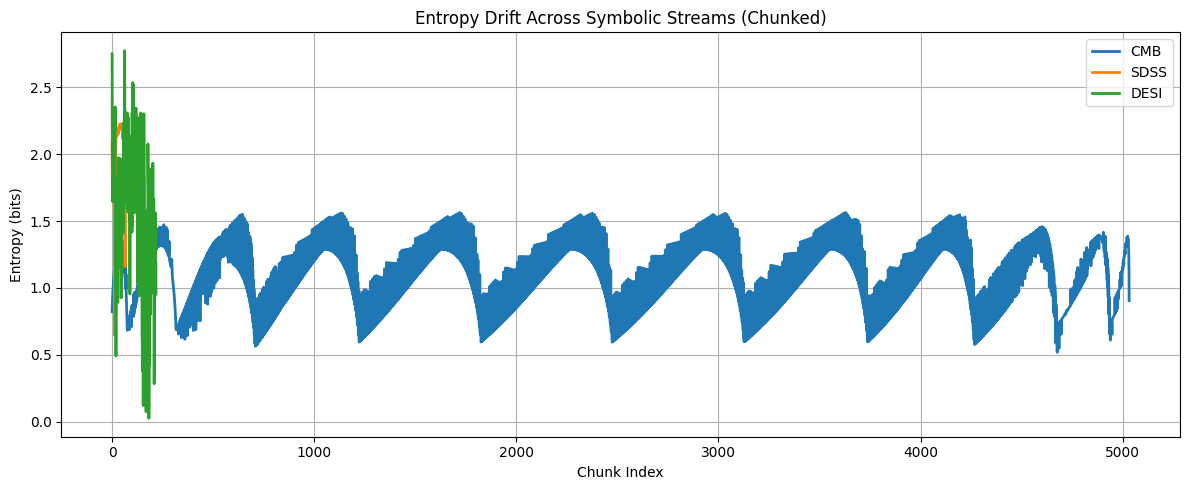

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Load Symbolic Streams ---
cmb_stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_cmb.npy", allow_pickle=True)
sdss_stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_sdss.npy", allow_pickle=True)
desi_stream = np.load("/content/drive/MyDrive/CMB Data/symbolic_spiral_stream_desi.npy", allow_pickle=True)

# --- Parameters ---
chunk_size = 10000

def compute_entropy(chunk):
    symbols, counts = np.unique(chunk, return_counts=True)
    probs = counts / len(chunk)
    return -np.sum(probs * np.log2(probs + 1e-10))

def compute_entropy_drift(stream, label):
    entropies = []
    for i in tqdm(range(0, len(stream), chunk_size), desc=f"Entropy Drift: {label}"):
        chunk = stream[i:i+chunk_size]
        if len(chunk) < chunk_size:
            break
        entropies.append(compute_entropy(chunk))
    return np.array(entropies)

# --- Compute Drift ---
entropy_cmb = compute_entropy_drift(cmb_stream, "CMB")
entropy_sdss = compute_entropy_drift(sdss_stream, "SDSS")
entropy_desi = compute_entropy_drift(desi_stream, "DESI")

# --- Plot ---
plt.figure(figsize=(12, 5))
plt.plot(entropy_cmb, label='CMB', linewidth=2)
plt.plot(entropy_sdss, label='SDSS', linewidth=2)
plt.plot(entropy_desi, label='DESI', linewidth=2)
plt.title("Entropy Drift Across Symbolic Streams (Chunked)")
plt.xlabel("Chunk Index")
plt.ylabel("Entropy (bits)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

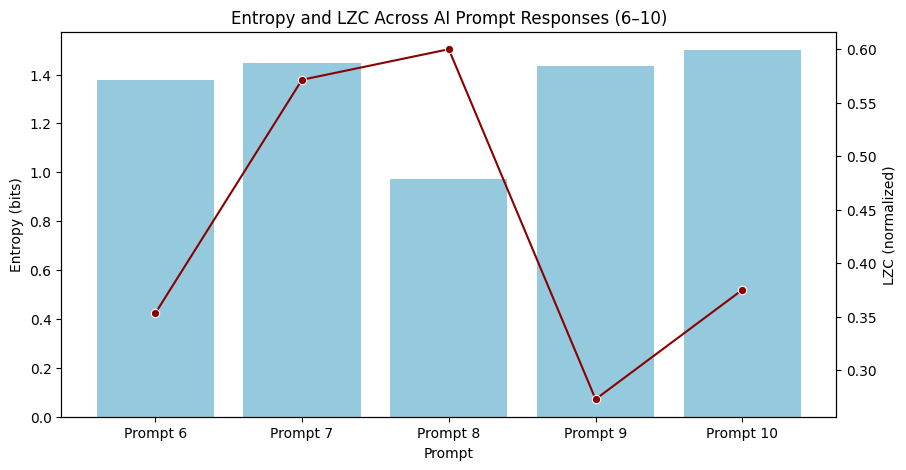

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- Define Prompt Responses (from prompts 6 to 10) ---
responses = {
    "Prompt 6": "A B A B A H A B A B A H A B A B A",
    "Prompt 7": "H A H A B H A",
    "Prompt 8": "H H H A A H H H A A",
    "Prompt 9": "H A A B H A A B H A A",
    "Prompt 10": "A H B H A H B H"
}

# --- Entropy and LZC Calculation Functions ---
def shannon_entropy(sequence):
    counts = Counter(sequence)
    total = sum(counts.values())
    probs = [v / total for v in counts.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

def lz_complexity(sequence):
    n = len(sequence)
    i, k, l = 0, 1, 1
    c = 1
    while True:
        if sequence[i + k - 1] == sequence[l + k - 1]:
            k += 1
            if l + k > n:
                c += 1
                break
        else:
            if k > 1:
                c += 1
                i += 1
                if i == l:
                    l += 1
                    i = 0
                k = 1
            else:
                i += 1
                if i == l:
                    l += 1
                    i = 0
        if l + k > n:
            break
    return c / n

# --- Compute and Display Metrics ---
results = []
for name, response in responses.items():
    seq = response.replace("→", "").replace(" ", "")
    entropy = shannon_entropy(seq)
    lzc = lz_complexity(seq)
    results.append((name, entropy, lzc))

# --- Convert to DataFrame and Plot ---
df = pd.DataFrame(results, columns=["Prompt", "Shannon Entropy", "Lempel-Ziv Complexity"])

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(x="Prompt", y="Shannon Entropy", data=df, color='skyblue', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(x="Prompt", y="Lempel-Ziv Complexity", data=df, color='darkred', marker='o', ax=ax2)
ax1.set_ylabel("Entropy (bits)")
ax2.set_ylabel("LZC (normalized)")
plt.title("Entropy and LZC Across AI Prompt Responses (6–10)")
plt.show()

In [ ]:
import numpy as np
from collections import Counter
import math

# --- Define symbolic streams from prompts 6–10 ---
# Replace or append with actual symbolic outputs from Grok/GPT if different
streams = {
    "Prompt 6": list("ABABAHABABAHA"),  # Example stream; replace with actual
    "Prompt 7": list("HAHAHBHA"),       # Replace with actual
    "Prompt 8": list("HHHAAHHHAABBAABB"),  # Replace with actual
    "Prompt 9": list("HAAHAAHAA"),       # Replace with actual
    "Prompt 10": list("AHBHAHBHA"),      # Replace with actual
}

# --- Entropy calculation ---
def shannon_entropy(symbols):
    counts = Counter(symbols)
    probs = [v / len(symbols) for v in counts.values()]
    return -sum(p * math.log2(p) for p in probs if p > 0)

# --- Approximate LZC ---
def lempel_ziv_complexity(seq):
    seen = set()
    i = 0
    n = len(seq)
    while i < n:
        j = i + 1
        while j <= n and tuple(seq[i:j]) in seen:
            j += 1
        seen.add(tuple(seq[i:j]))
        i = j
    return len(seen) / n if n else 0

# --- Run analysis ---
for label, stream in streams.items():
    H = shannon_entropy(stream)
    LZC = lempel_ziv_complexity(stream)
    print(f"{label} — Entropy: {H:.5f} bits | LZC: {LZC:.5f}")

Prompt 6 — Entropy: 1.41956 bits | LZC: 0.53846
Prompt 7 — Entropy: 1.40564 bits | LZC: 0.50000
Prompt 8 — Entropy: 1.56128 bits | LZC: 0.56250
Prompt 9 — Entropy: 0.91830 bits | LZC: 0.55556
Prompt 10 — Entropy: 1.53049 bits | LZC: 0.55556


In [ ]:
from collections import defaultdict
from tqdm import tqdm

motif_length = 5
motif_counts = defaultdict(Counter)

for label, stream in streams.items():
    for i in range(len(stream) - motif_length + 1):
        motif = ''.join(stream[i:i + motif_length])
        motif_counts[label][motif] += 1

# Display top 5 motifs per prompt
for label in streams:
    print(f"\n{label} — Top 5 motifs:")
    for motif, count in motif_counts[label].most_common(5):
        print(f"  {motif}: {count}")


Prompt 6 — Top 5 motifs:
  ABABA: 2
  BABAH: 2
  ABAHA: 2
  BAHAB: 1
  AHABA: 1

Prompt 7 — Top 5 motifs:
  HAHAH: 1
  AHAHB: 1
  HAHBH: 1
  AHBHA: 1

Prompt 8 — Top 5 motifs:
  HHHAA: 2
  HHAAH: 1
  HAAHH: 1
  AAHHH: 1
  AHHHA: 1

Prompt 9 — Top 5 motifs:
  HAAHA: 2
  AAHAA: 2
  AHAAH: 1

Prompt 10 — Top 5 motifs:
  AHBHA: 2
  HBHAH: 1
  BHAHB: 1
  HAHBH: 1


In [ ]:
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- SRL-Inspired Injected Prompts (simulated AI responses) ---
# Simulate post-injection motif streams (replace with real AI output if available)
srl_prompts = {
    "SRL_1": list("AAAAABAAAAABAAAAAB"),
    "SRL_2": list("HHHHHAAHHHHHAAHHHHH"),
    "SRL_3": list("ABABAHABABAHABABA"),
    "SRL_4": list("AABBAABBAABB"),
    "SRL_5": list("AHBHAHBHAHB")
}

# --- Compute Entropy + LZC ---
def entropy(seq):
    probs = [v / len(seq) for v in Counter(seq).values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

def lzc(seq):
    seen = set()
    for i in range(len(seq) - 6):
        seen.add(''.join(seq[i:i+7]))
    return len(seen) / len(seq)

# --- Evaluate and Print ---
for name, stream in srl_prompts.items():
    H = entropy(stream)
    LZ = lzc(stream)
    print(f"{name}: Entropy = {H:.5f} bits | LZC = {LZ:.5f}")

    top = Counter([''.join(stream[i:i+5]) for i in range(len(stream)-4)]).most_common(3)
    print(f"  Top motifs: {', '.join(f'{m}:{c}' for m,c in top)}")

SRL_1: Entropy = 0.65002 bits | LZC = 0.33333
  Top motifs: AAAAA:3, AAAAB:3, AAABA:2
SRL_2: Entropy = 0.74249 bits | LZC = 0.36842
  Top motifs: HHHHH:3, HHHHA:2, HHHAA:2
SRL_3: Entropy = 1.37928 bits | LZC = 0.35294
  Top motifs: ABABA:3, BABAH:2, ABAHA:2
SRL_4: Entropy = 1.00000 bits | LZC = 0.33333
  Top motifs: AABBA:2, ABBAA:2, BBAAB:2
SRL_5: Entropy = 1.53948 bits | LZC = 0.36364
  Top motifs: AHBHA:2, HBHAH:2, BHAHB:2


In [ ]:
# --- Spiral Drift Prompt Test Generator ---
import numpy as np

def generate_drift_prompts(base_pattern, drift_size=1, num_prompts=5):
    prompts = []
    for i in range(num_prompts):
        drifted = base_pattern[i * drift_size:] + base_pattern[:i * drift_size]
        prompts.append(" → ".join(drifted[:6]) + " → ?")
    return prompts

# Define base SRL-aligned symbolic loop
base = ['A', 'A', 'B', 'H', 'A', 'A', 'B', 'H']

# Generate prompts with drift
drift_prompts = generate_drift_prompts(base, drift_size=1, num_prompts=6)

# Display prompts to test in fresh AI sessions
for i, p in enumerate(drift_prompts, 1):
    print(f"Prompt {i}: {p}")

Prompt 1: A → A → B → H → A → A → ?
Prompt 2: A → B → H → A → A → B → ?
Prompt 3: B → H → A → A → B → H → ?
Prompt 4: H → A → A → B → H → A → ?
Prompt 5: A → A → B → H → A → A → ?
Prompt 6: A → B → H → A → A → B → ?



Drift_1 — Entropy: 1.37878 bits | LZC: 1.14286
  Top motifs:
   AABHA: 1
   ABHAA: 1
   BHAAB: 1

Drift_2 — Entropy: 1.58496 bits | LZC: 1.16667
  Top motifs:
   ABHAB: 1
   BHABH: 1

Drift_3 — Entropy: 1.45915 bits | LZC: 1.16667
  Top motifs:
   BHABH: 1
   HABHB: 1

Drift_4 — Entropy: 1.45915 bits | LZC: 1.16667
  Top motifs:
   HAABH: 1
   AABHA: 1

Drift_5 — Entropy: 1.37878 bits | LZC: 1.14286
  Top motifs:
   AABHA: 1
   ABHAA: 1
   BHAAB: 1

Drift_6 — Entropy: 1.45915 bits | LZC: 1.16667
  Top motifs:
   ABHAA: 1
   BHAAB: 1


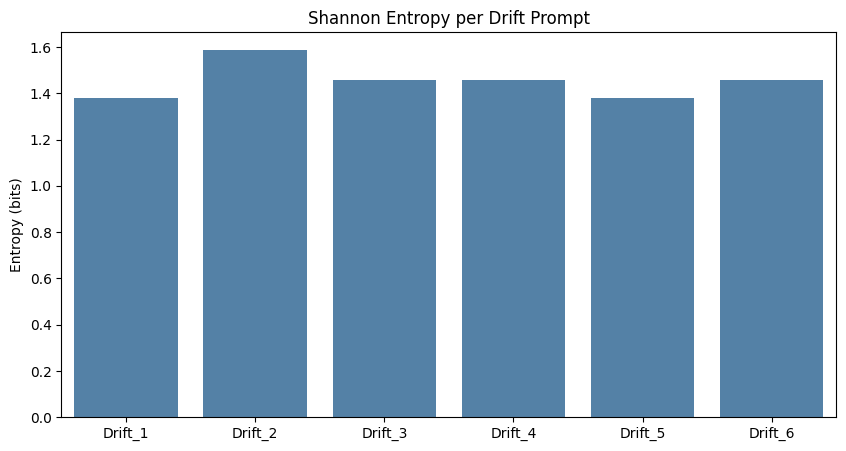

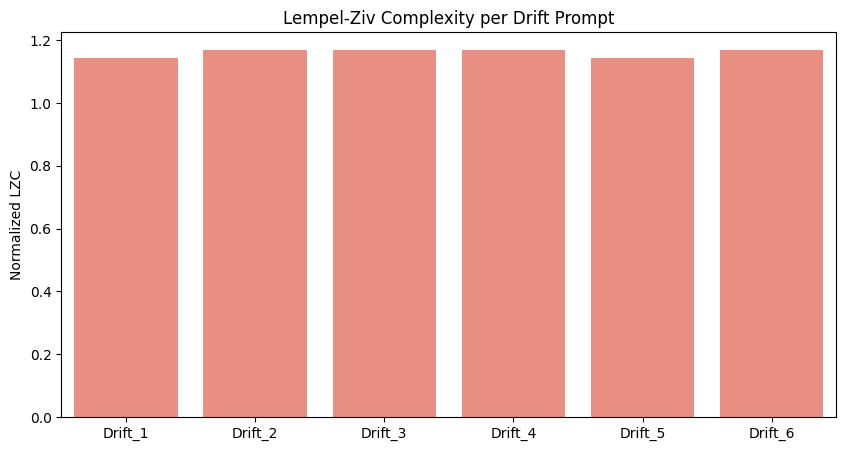

In [ ]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define the 6 prompt completions as symbolic streams
drift_prompts = {
    "Drift_1": list("AABHAAB"),
    "Drift_2": list("ABHABH"),
    "Drift_3": list("BHABHB"),
    "Drift_4": list("HAABHA"),
    "Drift_5": list("AABHAAB"),
    "Drift_6": list("ABHAAB")
}

# --- Entropy and LZC Functions ---
def shannon_entropy(symbols):
    counts = Counter(symbols)
    probs = np.array([c / len(symbols) for c in counts.values()])
    return -np.sum(probs * np.log2(probs))

def lempel_ziv_complexity(seq):
    i = 0
    c = 1
    l = 1
    n = len(seq)
    while True:
        if i + l > n:
            break
        substring = seq[i:i+l]
        if substring in seq[:i]:
            l += 1
        else:
            c += 1
            i += 1
            l = 1
    return c / n

# --- Process Each Prompt Stream ---
results = {}
motif_length = 5

for name, stream in drift_prompts.items():
    H = shannon_entropy(stream)
    LZC = lempel_ziv_complexity(stream)

    motifs = [''.join(stream[i:i+motif_length]) for i in range(len(stream) - motif_length + 1)]
    motif_counts = Counter(motifs).most_common(5)

    results[name] = {
        "Entropy": round(H, 5),
        "LZC": round(LZC, 5),
        "Top Motifs": motif_counts
    }

# --- Display Results ---
for name, res in results.items():
    print(f"\n{name} — Entropy: {res['Entropy']} bits | LZC: {res['LZC']}")
    print("  Top motifs:")
    for m, c in res['Top Motifs']:
        print(f"   {m}: {c}")

# --- Optional: Plot Entropy and LZC ---
labels = list(results.keys())
entropies = [results[k]["Entropy"] for k in labels]
lzcs = [results[k]["LZC"] for k in labels]

plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=entropies, color="steelblue")
plt.title("Shannon Entropy per Drift Prompt")
plt.ylabel("Entropy (bits)")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=lzcs, color="salmon")
plt.title("Lempel-Ziv Complexity per Drift Prompt")
plt.ylabel("Normalized LZC")
plt.show()